In [2]:
from marc_embeddings import lc
import itertools

P = 250000
N = 10000

records = list(itertools.islice(lc.load_from_xml('include/marc/BooksAll.2014.part01.xml'), 0, P, int(P/N)))
print("Loaded %i records" % len(records))

Loaded 10000 records


In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from marc_embeddings import marc

FIELDS = marc.select(marc.RelevantFields)

hv = HashingVectorizer(n_features = 40000, ngram_range = (1, 2), stop_words='english')
tfidf = TfidfTransformer()

vectorizer = Pipeline([
    ('features', FeatureUnion(
        list(map(lambda field: (field, Pipeline([
            ('read xml', lc.LCTransformer([field])),
            ('flatten', lc.FlattenTransformer()),
            ('hash, tf-idf', Pipeline([
                ('hash', hv),
                ('tf-idf', tfidf)
            ]))
        ])), FIELDS))
    )),
    ('reduce dimensions', TruncatedSVD(300)),
    ('normalize to unit value', Normalizer(copy = False))
])

X = vectorizer.fit_transform(records)

In [78]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()

model = Pipeline([
    ('cluster', dbscan)
])

model.fit(X)

from sklearn import metrics

print(metrics.silhouette_score(X, dbscan.labels_))
print(metrics.calinski_harabaz_score(X, dbscan.labels_))

-0.01563565714330547
27.513753191759864


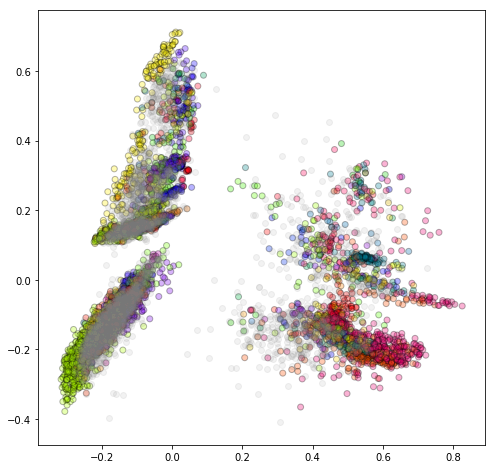

In [61]:
# Visualize the records in two dimensions with PCA, color by cluster.

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_pca_labeled = list(zip(PCA(2).fit_transform(X), dbscan.labels_))

X_pca_noise = list(filter(lambda x: x[1] < 0, X_pca_labeled))
X_pca_cluster = list(filter(lambda x: x[1] >= 0, X_pca_labeled))

c_noise = [x[1] for x in X_pca_noise]
c_cluster = [x[1] for x in X_pca_cluster]

X_pca_noise_1 = [x[0][0] for x in X_pca_noise]
X_pca_noise_2 = [x[0][1] for x in X_pca_noise]

X_pca_cluster_1 = [x[0][0] for x in X_pca_cluster]
X_pca_cluster_2 = [x[0][1] for x in X_pca_cluster]

plt.figure(figsize=(8, 8))
plt.scatter(X_pca_cluster_1, X_pca_cluster_2, c = c_cluster, cmap = 'prism', edgecolors='black', alpha = 0.3)
plt.scatter(X_pca_noise_1, X_pca_noise_2, c = 'gray', alpha = 0.1)

In [81]:
from numpy import histogram

print("%i clusters" % (len(set(dbscan.labels_)) - 1))
print("%d%% noise" % (100 * histogram(dbscan.labels_)[0][0] / N))

199 clusters
63% noise
